# Tutorial demonstrating the basic functionality of the `iwatlas` package

In this tutorial we will learn how to:

 - Download the data netcdf4 file
 - Inspect the data
 - Plot a variable
 - Interpolate a scalar onto a point
 - Extract a time-series of internal tide sea surface height amplitude at a point
     - demonstrate the use of nodal corrections
 - Extract the stratification at a point
 - Extract the internal tide-induced velocity at a point
     - demonstrate the use of nodal corrections
---

 

##### Recommended to start a fresh environment
`conda create --name iwatlas_env python=3.12`

`conda activate iwatlas_env`

##### Install iwatlas

`pip install git+https://github.com/williamedge/iwatlas.git`

`pip install ipykernel`

`pip install xarray numpy pandas matplotlib scipy`

---

#### Links to important dependencies 

Sfoda

`pip install git+https://github.com/mrayson/sfoda.git@nogdal_nocython`

Iwaves

`pip install git+https://github.com/mrayson/iwaves.git`

Need to install pyTMD version 2.2.7... this should do it for now:

`pip install git+https://github.com/pyTMD/pyTMD.git@2.2.7`



In [1]:
# These are the sub-modules in the iwatlas package that we will use
from iwatlas import sshdriver
from iwatlas import uvdriver
from iwatlas import harmonics
from iwatlas import stratification as strat
from iwatlas import iwaves
import iwatlas
print(iwatlas.__file__)

import xarray as xr
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

/home/wedge/anaconda3/envs/iwatlas_env/lib/python3.12/site-packages/iwatlas/__init__.py


In [2]:
# import sfoda
# sfoda.__file__

In [3]:
# Uncomment this option to allow for interactive plot windows (e.g. zooming)
# %matplotlib notebook

In [4]:
# Set where you want to download the 200 MB data file
# basedir = '/home/jupyter-ubuntu/data/iwatlas'
basedir = '../DATA'

In [5]:
%%time
# Download the data if it does not exist
import urllib, os

# Link to a 200 MB data file on cloudstor
# publicurl = 'https://cloudstor.aarnet.edu.au/plus/s/vdksw5WKFOTO0nD/download'
publicurl = 'https://research-repository.uwa.edu.au/files/93942498/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc'
atlasfile = '{}/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc'.format(basedir)

if os.path.exists(basedir):
    print('Folder exists.')
else:
    print('Making folder {}'.format(basedir))
    os.mkdir(basedir)
    
if os.path.exists(atlasfile):
    print('File exists.')
else:
    print('Downloading file...')
    urllib.request.urlretrieve (publicurl, atlasfile)
    print('Done. Saved to {}'.format(atlasfile))
atlasfile

Folder exists.
File exists.
CPU times: user 1.75 ms, sys: 136 μs, total: 1.88 ms
Wall time: 3.06 ms


'../DATA/NWS_2km_GLORYS_hex_2013_2014_InternalWave_Atlas.nc'

# Example 1: Open the dataset 

For this we will use the function `sshdriver.load_ssh_clim` method. This method wraps the `sfoda.ugrid.sunxray.Sunxray` class that is basically an unstructured grid `xarray.Dataset` object.

sfoda updates
 - in hybridgrid replace `xrange` with `range` and `if not self._pnt2cells.has_keys(cc):` with `if not cc in self._pnt2cells:`

In [6]:
ssh = sshdriver.load_ssh_clim(atlasfile)
ssh = sshdriver.load_ssh_clim(ssh)
ssh._ds

<xarray.Dataset> Size: 265MB
Dimensions:     (Nc: 225368, numsides: 8, Np: 454016, Nmode: 4, Nk: 80,
                 Nparams: 7, Nannual: 4, Ntide: 35, Nkw: 81)
Coordinates:
    Nk          (Nc) int32 901kB 74 76 76 75 73 74 77 ... 79 79 79 79 79 79 79
    xv          (Nc) float64 2MB ...
    yv          (Nc) float64 2MB ...
    z_w         (Nkw) float64 648B ...
    omegaA      (Nannual) float64 32B ...
    params      (Nparams) int64 56B ...
    omega       (Ntide) float64 280B ...
Dimensions without coordinates: Nc, numsides, Np, Nmode, Nparams, Nannual,
                                Ntide, Nkw
Data variables: (12/15)
    cells       (Nc, numsides) int32 7MB 3058 3061 3060 2801 ... 316187 -1 -1
    xp          (Np) float64 4MB 1.394e+07 1.271e+07 ... 1.303e+07 1.303e+07
    yp          (Np) float64 4MB -1.619e+06 -2.553e+06 ... -2.056e+06 -2.055e+06
    nfaces      (Nc) int32 901kB ...
    dv          (Nc) float64 2MB ...
    modes       (Nmode) float64 32B ...
    ...          ...
    N2_re       (Nannual, Nparams, Nc) float64 50MB ...
    N2_im       (Nannual, Nparams, Nc) float64 50MB ...
    SSH_BC_var  (Nc) float64 2MB ...
    SSH_BC_aa   (Nc) float64 2MB ...
    SSH_BC_Aa   (Ntide, Nc) float64 63MB ...
    SSH_BC_Ba   (Ntide, Nc) float64 63MB ...
Attributes:
    Description:              Internal wave and density stratification climat...
    Author:                   Matt Rayson (matt.rayson@uwa.edu.au)
    Created:                  2020-11-09 14:18:38.187611
    Title:                    SUNTANS density stratification climatology
    density_func:             double_gaussian_N2_v2
    density_func_tex:         N^2(z) = \beta_0 + \beta_1  \left( \beta_6* \ex...
    Number_Annual_Harmonics:  3
    ReferenceDate:            1990-01-01T00:00:00

We can see from the printout above the *coordinate* and *data variables* plus some *global attributes*. Many of the coordinate and data variables are associated with the unstructured grid topology (e.g., $xv$, $cells$, $nfaces$). The data variables of interest are stored as follows:

 - Sea surface height harmonics: `SSH_BC_*`
 - Stratification variables: `N2_*`
 

# Example 2: Inspect an individual variable

The `xarray.Dataset` class is the `._ds` attribute. To access a variable (an `xarray.DataArray` object) we call `ssh._ds[varname]`.

In [7]:
ssh._ds['SSH_BC_var']

<xarray.DataArray 'SSH_BC_var' (Nc: 225368)> Size: 2MB
[225368 values with dtype=float64]
Coordinates:
    Nk       (Nc) int32 901kB 74 76 76 75 73 74 77 76 ... 79 79 79 79 79 79 79
    xv       (Nc) float64 2MB ...
    yv       (Nc) float64 2MB ...
Dimensions without coordinates: Nc
Attributes:
    long_name:  SSH_BC - signal variance
    units:      m^2

# Example 3: Plot a spatial variable

The data is on an unstructured grid so we call either `plotcelldata` or `contourf` methods in the object.

In [8]:
# To show help for a method within an object use the ? symbol e.g.,
ssh.plotcelldata?

Signature:
ssh.plotcelldata(
    z,
    xlims=None,
    ylims=None,
    colorbar=True,
    vmin=None,
    vmax=None,
    cbar_kwargs={},
    **kwargs,
)
Docstring: Plot cell centered data
File:      ~/anaconda3/envs/iwatlas_env/lib/python3.12/site-packages/sfoda/ugrid/uplot.py
Type:      method

Text(0.5, 1.0, 'SSH_BC - signal variance')

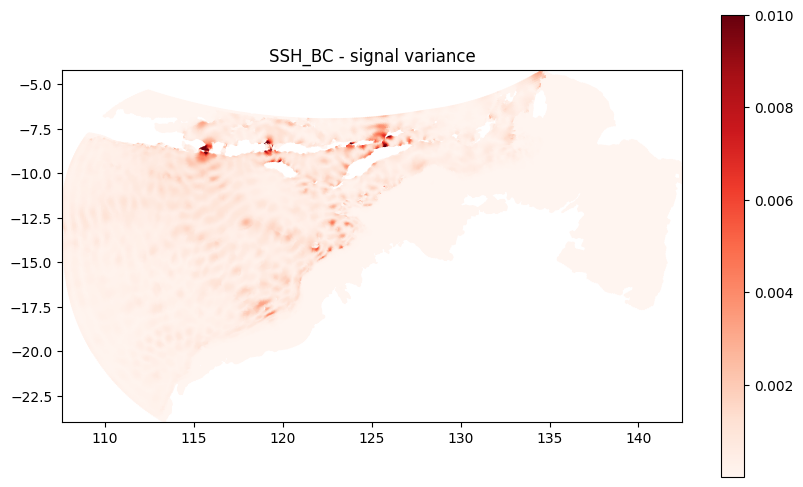

In [9]:
# Plot the Sea surface height signal variance
plt.figure(figsize=(10,6))
ssh.plotcelldata(ssh._ds['SSH_BC_var'], vmax=1e-2, cmap='Reds')
plt.title(ssh._ds['SSH_BC_var'].attrs['long_name'])

This is nice but it is hard to see any landmarks. Let's add some bathymetry contours...

Text(0.5, 1.0, 'SSH_BC - signal variance')

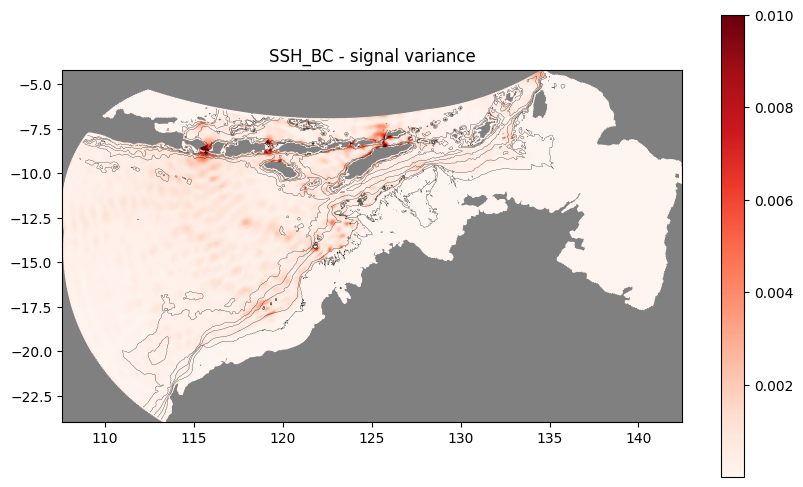

In [10]:
plt.figure(figsize=(10,6))
ax=plt.subplot(111,facecolor='0.5')
ssh.plotcelldata(ssh._ds['SSH_BC_var'], vmax=1e-2, cmap='Reds')
ssh.contourf(ssh._ds['dv'], [100, 200,  500, 1000, 2000], colors='k', linewidths=0.2, filled=False, colorbar=False)
plt.title(ssh._ds['SSH_BC_var'].attrs['long_name'])

# Example 4: Interpolate a scalar onto a point

The `sunxray` object has a convenient `.interpolate` method to extract a scalar from the unstructured grid.


In [11]:
# WA-IMOS locations (August 2019)
sites = {
'NIN100':{'y':-21.84986667,'x':113.9064667},
'NWSBAR':{'y':-20.76128333,'x':114.7586167},
'NWSROW':{'y':-17.75801667,'x':119.9061},
'NWSBRW':{'y':-14.23543333,'x':123.1623833},
'NWSLYN':{'y':-9.939416667,'x':130.3490833},
'PIL200':{'x': 115.9154, 'y':-19.435333}   ,
'KIM200':{'x':121.243217 , 'y':-15.534517} ,  
'KIM400':{'x': 121.114967, 'y':-15.22125}   ,
'ITFTIS':{'x': 127.5577, 'y':-9.819217}   ,
'BB250':{'x':123.34613 , 'y':-13.75897}  ,
'Prelude':{'x':123.3506, 'y':-13.7641} , 
}

In [12]:
# Spatial coordinates of point
sitename = 'NWSBAR'
xpt = sites[sitename]['x']
ypt = sites[sitename]['y']

# Call to the interpolation method
mydata = ssh.interpolate(ssh._ds['SSH_BC_var'].values, xpt, ypt, kind='linear')

print('The SSH variance at X: {} Y: {} is {}'.format(\
                    xpt, ypt, mydata ) )

The SSH variance at X: 114.7586167 Y: -20.76128333 is 0.0003040768282197015


# Example 5: Extract a time-series of baroclinic sea surface height anomaly

To do this we use the driver functions in the `iwatlas.sshdriver` submodule. In particular the `predict_ssh` method



In [13]:
sshdriver.predict_ssh?

Signature: sshdriver.predict_ssh(sshfile, x, y, time, kind='linear', nodal=True)
Docstring: Perform harmonic predictions at the points in x and y
File:      ~/anaconda3/envs/iwatlas_env/lib/python3.12/site-packages/iwatlas/sshdriver.py
Type:      function

Text(0, 0.5, '$SSH_{BC}$ [m]')

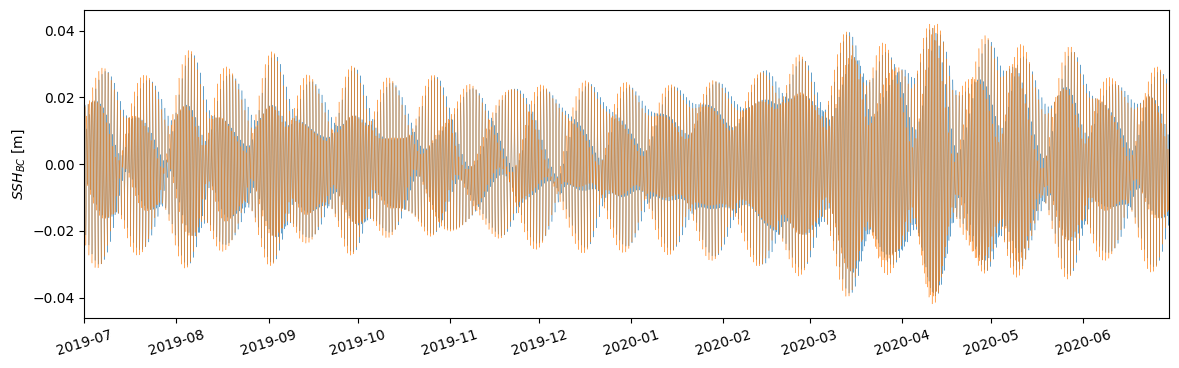

In [14]:
# Create a time vector
dt = 1800
numdays = 365
tstart = np.datetime64('2019-07-01 00:00:00')

nsteps = numdays*86400//dt
timeout = np.array([tstart+np.timedelta64(ii*dt,'s') for ii in range(nsteps)])

# Call the prediction funciton
ssh_ts_old = sshdriver.predict_ssh(ssh, xpt, ypt, timeout, nodal=False)
ssh_ts_nodal = sshdriver.predict_ssh(ssh, xpt, ypt, timeout, nodal=True)

# Plot the time series
plt.figure(figsize=(14,4))
plt.plot(timeout, ssh_ts_old, lw=0.25)
plt.plot(timeout, ssh_ts_nodal, lw=0.25)
plt.xlim(timeout[0], timeout[-1])
plt.xticks(rotation=17)
plt.ylabel('$SSH_{BC}$ [m]')

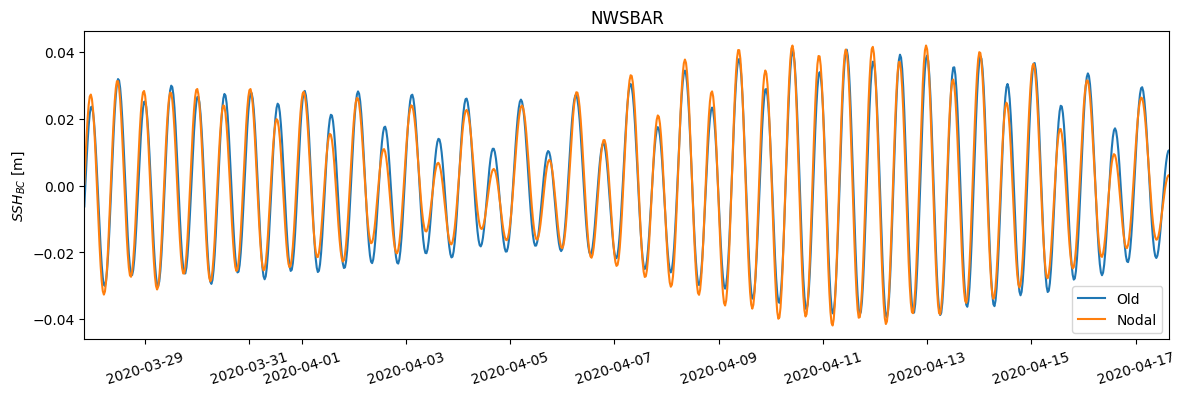

In [15]:
px = np.arange(13000,14000)

# Plot the time series
plt.figure(figsize=(14,4))
plt.plot(timeout[px], ssh_ts_old[px], lw=1.5, label='Old')
plt.plot(timeout[px], ssh_ts_nodal[px], lw=1.5, label='Nodal')
plt.xlim(timeout[px][0], timeout[px][-1])
# plt.grid()
plt.xticks(rotation=17)
plt.ylabel('$SSH_{BC}$ [m]')
plt.title(sitename)
plt.legend()

Maybe we also want to look at the contributions from the individual harmonics to this signal and how they vary. To do this use the `extract_amp_nonstat` function.

This outputs two arrays, the real and imaginary amplitude, for each harmonic

/home/wedge/anaconda3/envs/iwatlas_env/lib/python3.12/site-packages/iwatlas/sshdriver.py:131: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ntide = sshobj._ds.dims['Ntide']//(2*na+1)


Text(0, 0.5, '$SSH_{BC}$ [m]')

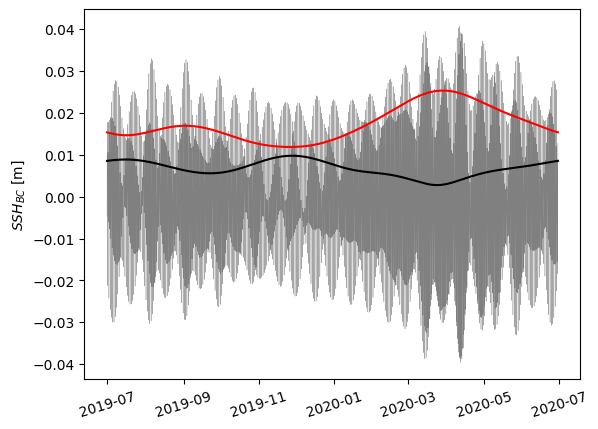

In [16]:
ssh_ns_re, ssh_ns_im = sshdriver.extract_amp_nonstat(ssh, np.array([xpt]), np.array([ypt]), timeout)

# To plot the amplitude of the first harmonic (M2) use the
plt.figure()
plt.plot(timeout, ssh_ts_old, '0.5', lw=0.25)
plt.plot(timeout, np.abs(ssh_ns_re[0,...] + 1j*ssh_ns_im[0,...]), 'r', ) # M2
plt.plot(timeout, np.abs(ssh_ns_re[3,...] + 1j*ssh_ns_im[3,...]), 'k', ) # K1

plt.xticks(rotation=17)
plt.ylabel('$SSH_{BC}$ [m]')


# Example: Extract the density stratification at a point

Use the `iwatlas.stratification` module to extract density (buoyancy frequency) profile

In [17]:
strat.predict_N2?

Signature: strat.predict_N2(N2file, xpt, ypt, timept, nz, density_func=None, **kwargs)
Docstring:
Return a buoyancy frequency squared (N^2) vertical profile at a space-time location of choice

Inputs:
---
    N2file: filename of the stratification climatology dataset (NWS_2km_GLORYS_hex_2013_2014_Stratification_Atlas.nc)
    xpy,ypt: vectors [nx] of output space points
    timept: vector [nt] of datetime64 time objects
    nz: scalar with number of sigma layers

Returns:
    N2_z: array of buoyancy frequency [nz, nx, nt]
File:      ~/anaconda3/envs/iwatlas_env/lib/python3.12/site-packages/iwatlas/stratification.py
Type:      function

In [18]:
# 
nz = 80 # Number of vertical layers to output

# Call the predict_N2 method. Note that this function expects numpy arrays, not scalars, for all inputs

# Only compute N^2 at a few time steps
tsteps = [0,7200,13200]
N2_z, zout = strat.predict_N2(ssh, np.array([xpt]), np.array([ypt]), timeout[tsteps], nz)


/home/wedge/anaconda3/envs/iwatlas_env/lib/python3.12/site-packages/iwatlas/stratification.py:123: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  na = ds_N2._ds.dims['Nannual']
/home/wedge/anaconda3/envs/iwatlas_env/lib/python3.12/site-packages/iwatlas/stratification.py:124: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nparams = ds_N2._ds.dims['Nparams']
/home/wedge/anaconda3/envs/iwatlas_env/lib/python3.12/site-packages/iwatlas/stratification.py:94: RuntimeWarning: divide by zero encountered in log
  zpr = -np.log(zout)


In [19]:
# Convert N^2 to units of cycles per day
cpd = 2*np.pi/86400.
N_cpd = np.sqrt(N2_z)/cpd
86400/600.

144.0

Text(0.5, 0, '$N$ [cpd]')

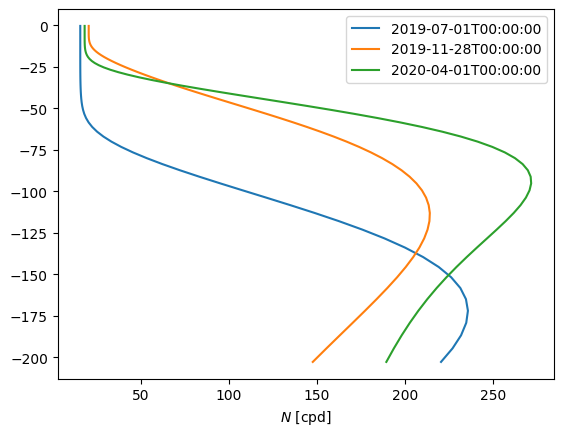

In [20]:
plt.figure()
plt.plot(N_cpd[:,0,0], -zout[:,0,0], )
plt.plot(N_cpd[:,0,1], -zout[:,0,1], )
plt.plot(N_cpd[:,0,2], -zout[:,0,2], )

plt.legend(timeout[tsteps])
plt.xlabel('$N$ [cpd]')

# Calculate the internal wave parameters


In [21]:
# Calculate the internal wave parameters
mode= 0 

# Mode shapes
phi_n, cn = iwaves.calc_modes(N2_z, zout, mode=mode)

# KdV nonlinearity parameter
alpha = iwaves.calc_alpha(phi_n, cn, zout)

# KdV dispersion parameter
beta = iwaves.calc_beta(phi_n, cn, zout)

# Factor to convert SSH to isotherm displacement amplitude
sshratio = iwaves.amp_to_ssh_ratio(N2_z, phi_n, zout)
print(cn[0,0], alpha[0,0], beta[0,0], sshratio[0,0])

0.7325439853768456 0.011838882268500514 1272.5880012338225 579.1016723452591


# Example: convert SSH prediction to isotherm displacement amplitude


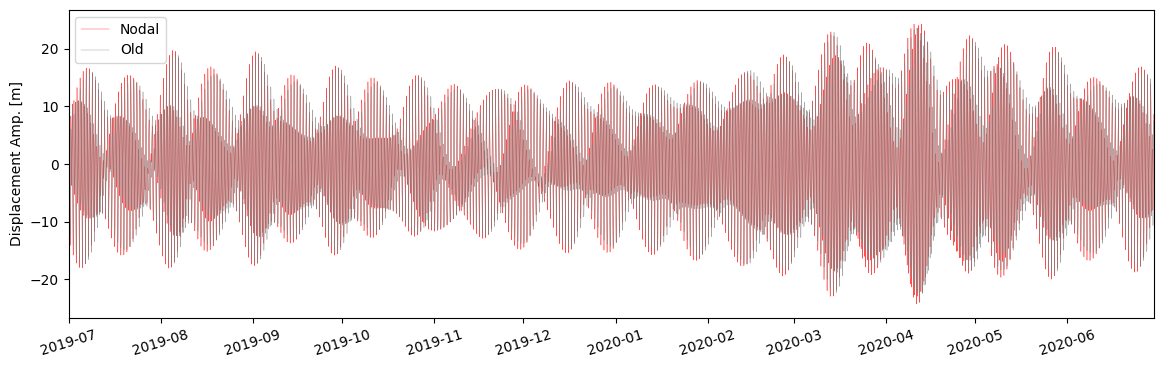

In [22]:
# This is simply the sshratio multiplied by the SSH
amp_ts_old = ssh_ts_old*sshratio[0,0]
amp_ts_nodal = ssh_ts_nodal*sshratio[0,0]
plt.figure(figsize=(14,4))
plt.plot(timeout, amp_ts_nodal, 'r', lw=0.25, label='Nodal')
plt.plot(timeout, amp_ts_old, '0.5', lw=0.25, label='Old')
plt.xlim([timeout[0], timeout[-1]])
plt.xticks(rotation=17)
plt.ylabel('Displacement Amp. [m]')
plt.legend()

# Example: convert SSH to a baroclinic velocity prediciton

In [23]:
# Predict the time series of amplitude (note this needs to be expanded in the vertical direction)
ut_old, vt_old = uvdriver.predict_uv(ssh, np.array([xpt]), np.array([ypt]), timeout, nodal=False)
ut_nodal, vt_nodal = uvdriver.predict_uv(ssh, xpt, ypt, timeout, nodal=True)


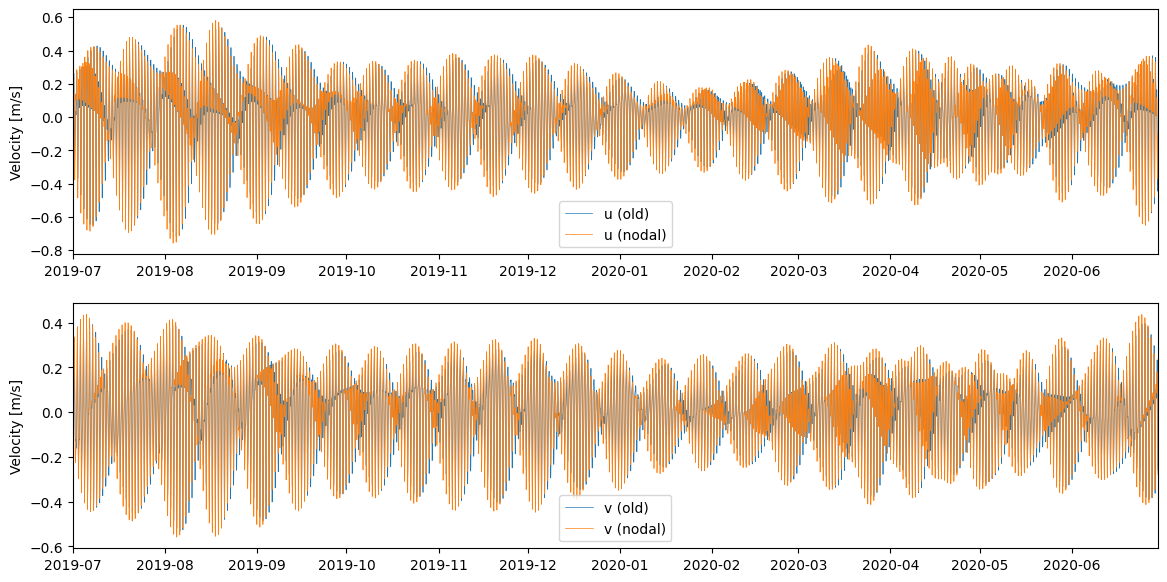

In [24]:
fig, ax = plt.subplots(2, 1, figsize=(14,7))
ax[0].plot(timeout, ut_old, label='u (old)', lw=0.5)
ax[0].plot(timeout, ut_nodal, label='u (nodal)', lw=0.5)

ax[1].plot(timeout, vt_old, label='v (old)', lw=0.5)
ax[1].plot(timeout, vt_nodal, label='v (nodal)', lw=0.5)

for x in ax:
    x.set_xlim(timeout[0], timeout[-1])
    x.legend()
    x.set_ylabel('Velocity [m/s]')

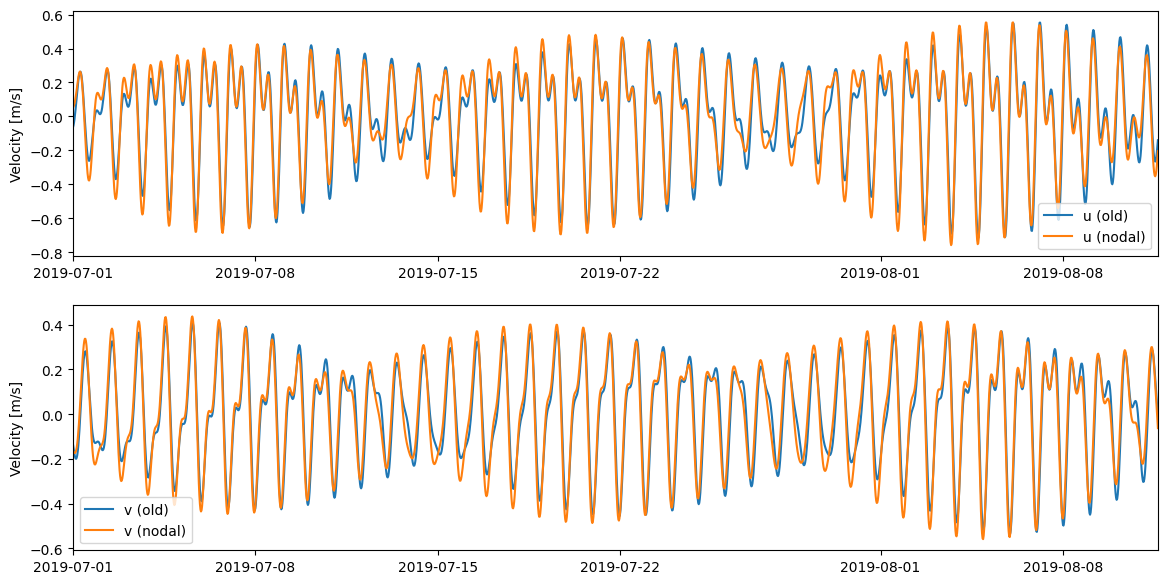

In [25]:
px = np.arange(0,2000)

fig, ax = plt.subplots(2, 1, figsize=(14,7))
ax[0].plot(timeout[px], ut_old[px], label='u (old)')
ax[0].plot(timeout[px], ut_nodal[px], label='u (nodal)')

ax[1].plot(timeout[px], vt_old[px], label='v (old)')
ax[1].plot(timeout[px], vt_nodal[px], label='v (nodal)')

for x in ax:
    x.set_xlim(timeout[px][0], timeout[px][-1])
    x.legend()
    x.set_ylabel('Velocity [m/s]')

In [26]:
%%time
# Compute the velocity as a function of z 
# this requires calculating vertical mode function for every time step so may take a minute or two

pred = 1000 # predict for the first 1000 time steps

uz, vz, zout = uvdriver.predict_uv_z(ssh, np.array([xpt]), np.array([ypt]), timeout[:pred], nodal=False)
uz_nodal, vz_nodal, zout_nodal = uvdriver.predict_uv_z(ssh, xpt, ypt, timeout[:pred], nodal=True)
print(uz.shape)

(80, 1, 1000)
CPU times: user 24.6 s, sys: 595 ms, total: 25.2 s
Wall time: 25.7 s


In [27]:
depth_pred = 20 # 20 m depth
zout_idx = np.argmin(np.abs(zout.data[:,0,0] - depth_pred))
zout_idx

np.int64(29)

Text(0.5, 1.0, 'NWSBAR: velocity at 20.3 m depth')

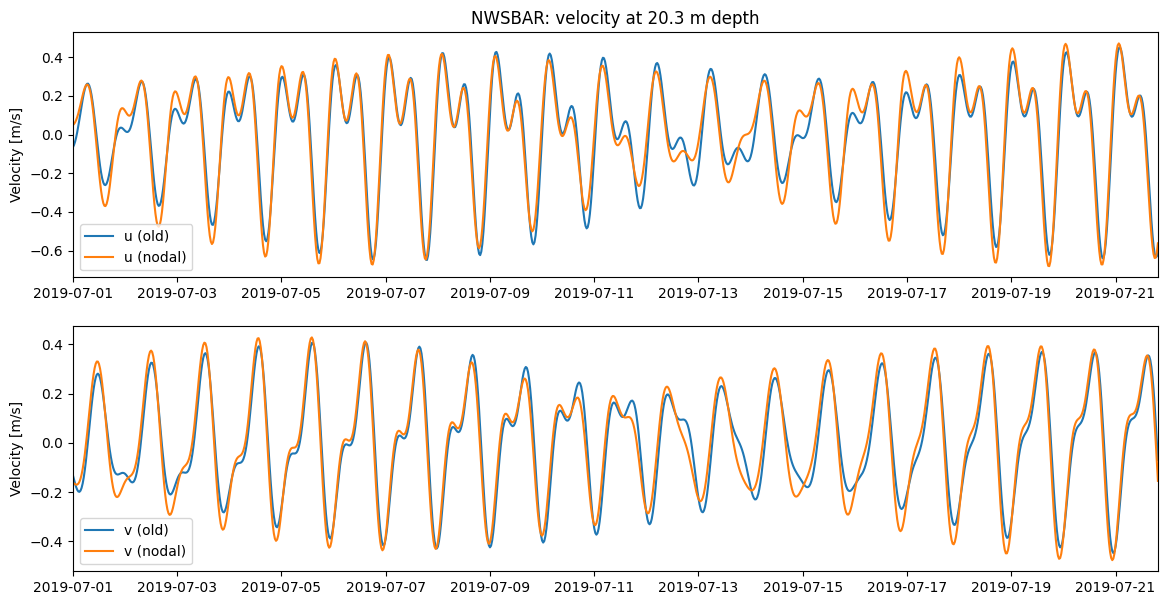

In [28]:
# Plot the surface velocity
usurf = uz[zout_idx,0,...]
vsurf = vz[zout_idx,0,...]

fig, ax = plt.subplots(2, 1, figsize=(14,7))
ax[0].plot(timeout[:pred], usurf, lw=1.5, label='u (old)')
ax[0].plot(timeout[:pred], uz_nodal[0,0,...], lw=1.5, label='u (nodal)')

ax[1].plot(timeout[:pred], vsurf, lw=1.5, label='v (old)')
ax[1].plot(timeout[:pred], vz_nodal[0,0,...], lw=1.5, label='v (nodal)')

for x in ax:
    x.set_ylabel('Velocity [m/s]')
    x.legend()
    x.set_xlim(timeout[0], timeout[pred-1])
ax[0].set_title(f'{sitename}: velocity at {zout.data[zout_idx,0,0]:.1f} m depth')